#Feature Importance, Correlation, Prediction Modeling Notebook

In [27]:
# Install & import packages
%%capture
!pip install --upgrade --no-cache-dir gdown
!pip install geopandas

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve

In [2]:
# Download the processed data from 'Feature Extraction Notebook'
!gdown --id 1xqauravEeLbtJGCM4fQVH5wERdZECFIU

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1xqauravEeLbtJGCM4fQVH5wERdZECFIU
To: /content/cell_agg_all_NYC.geojson
100% 194M/194M [00:02<00:00, 69.2MB/s]


### 1. Feature Importance

In [3]:
# Filter the data for feature importance, keeping only the 311 complaints columns and the Crime column
cell_aggr_df = gpd.read_file("cell_agg_all_NYC.geojson")
cell_aggr_df_FI = cell_aggr_df.drop(columns=['geometry','Liquor_License'])
feature_im_df = pd.DataFrame(cell_aggr_df_FI).drop(columns=['Elevator', 'Taxi Complaint', 'For Hire Vehicle Complaint', 'APPLIANCE', 'Non-Emergency Police Matter']) # Inrelevant Columns
feature_im_df.shape

(30351, 222)

In [4]:
# Prep X, y for algo
X = feature_im_df.drop(columns=['Crime'])
y = feature_im_df['Crime']   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=35)

In [5]:
# Use Gradient Boosting to build a tree, then find the feature importance in the model
FI_model = GradientBoostingRegressor(random_state=35,
                                n_estimators=200,
                                max_depth=5)
FI_model.fit(X_train, y_train)

y_train_pred = FI_model.predict(X_train)
y_test_pred = FI_model.predict(X_test)

In [8]:
mae = metrics.mean_absolute_error(y_train, y_train_pred)
mse = metrics.mean_squared_error(y_train, y_train_pred)
r2 = metrics.r2_score(y_train, y_train_pred)

print("The model performance for training set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2), '\n')

mae = metrics.mean_absolute_error(y_test, y_test_pred)
mse = metrics.mean_squared_error(y_test, y_test_pred)
r2 = metrics.r2_score(y_test, y_test_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
MAE is 3.4268404871907645
MSE is 105.74908048230603
R2 score is 0.9536534417149141 

The model performance for testing set
--------------------------------------
MAE is 6.589649352190898
MSE is 752.4945257459127
R2 score is 0.644842240417876


In [12]:
# Extract feature importance from the model
column_names = feature_im_df.columns
FI_model.feature_importances_.shape

%matplotlib inline  
top_10 = pd.Series(FI_model.feature_importances_, index=X.columns).nlargest(10)
     
top10names = top_10.index

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


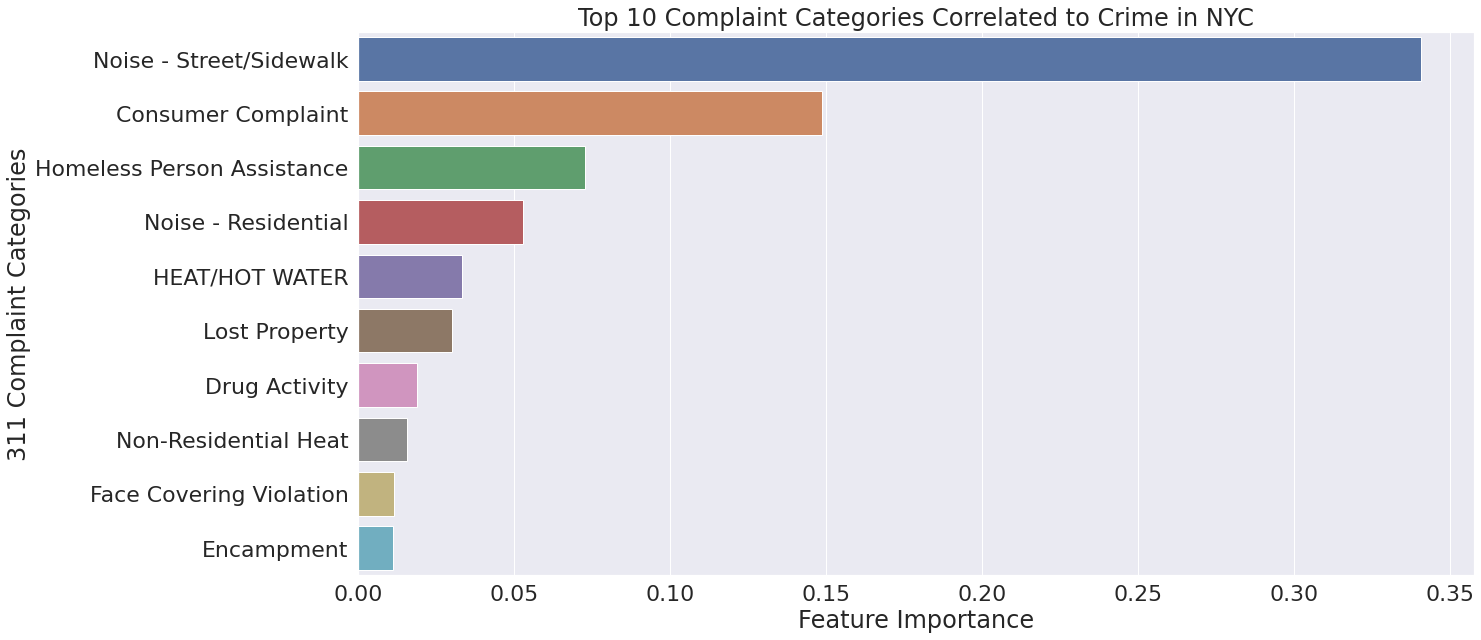

In [13]:
# Plot the feature importance for the top10 of them
sns.set_theme(style="darkgrid")
plt.figure(figsize=(20,10))
sns.set(font_scale = 2)
fig = sns.barplot(top_10.values, top_10.index)
plt.xlabel('Feature Importance')
plt.ylabel('311 Complaint Categories')
plt.title("Top 10 Complaint Categories Correlated to Crime in NYC") 
plt.show(fig)

### 2. Correlation Heatmaps

In [16]:
# Extract the variables of interest 
target = ['Crime'] + list(top10names)
corr_10_df = cell_aggr_df_FI[target]

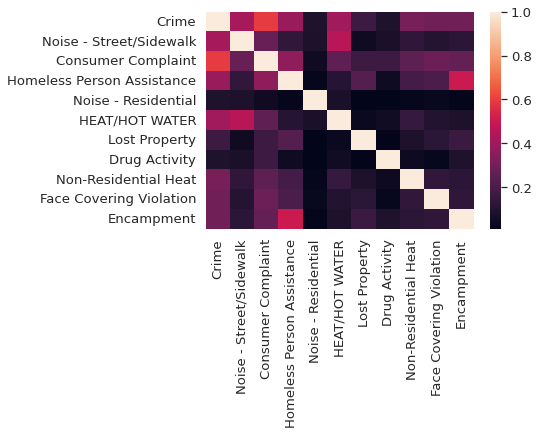

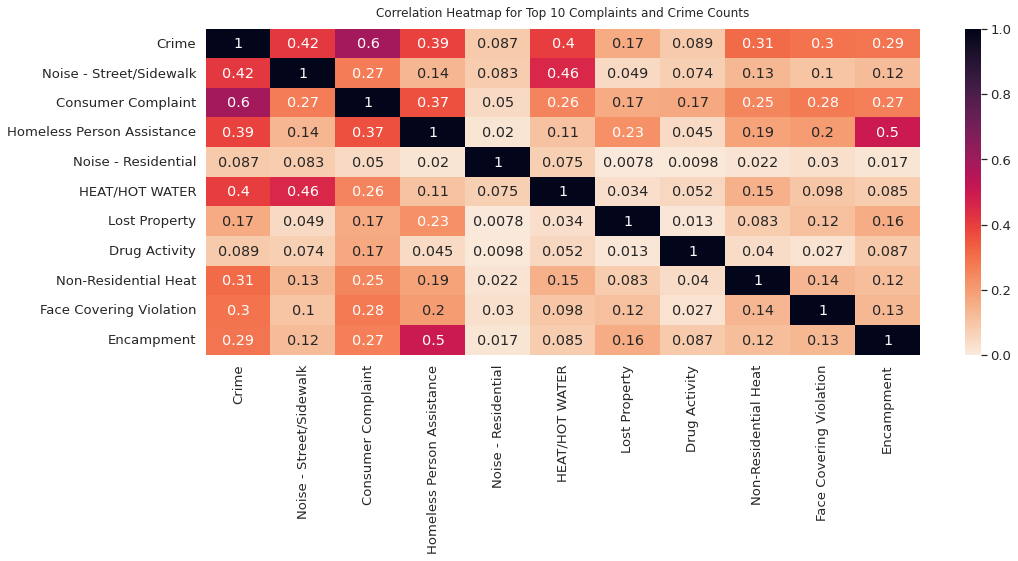

In [18]:
sns.set(font_scale = 1.2)

# Heatmap w/out the correlation coefficient
sns.heatmap(corr_10_df.corr());
plt.figure(figsize=(16, 6))

# Heatmap wthe correlation coefficient
heatmap = sns.heatmap(corr_10_df.corr(), vmin=0, vmax=1, annot=True, cmap='rocket_r')
heatmap.set_title('Correlation Heatmap for Top 10 Complaints and Crime Counts', fontdict={'fontsize':12}, pad=12);

### 3. Prediction
Utilize the 311 complaints count and liquor store distribution, predict the number of crime in each cell

In [34]:
# Rebuild the train-test split
predict_df = pd.DataFrame(cell_aggr_df.drop(columns=['geometry'])) # including the liquor store data

X = predict_df.drop(columns=['Crime'])
y = predict_df['Crime']   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=32)

In [20]:
predict_model = GradientBoostingRegressor(random_state=35,
                                n_estimators=200,
                                max_depth=5)
predict_model.fit(X_train, y_train)

y_train_pred = predict_model.predict(X_train)
y_test_pred = predict_model.predict(X_test)

In [21]:
print("#########################################################")
mae = metrics.mean_absolute_error(y_train, y_train_pred)
mse = metrics.mean_squared_error(y_train, y_train_pred)
r2 = metrics.r2_score(y_train, y_train_pred)

print("The model performance for training set on Predicting Crime")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

print("#########################################################")

mae = metrics.mean_absolute_error(y_test, y_test_pred)
mse = metrics.mean_squared_error(y_test, y_test_pred)
r2 = metrics.r2_score(y_test, y_test_pred)

print("The model performance for testing set on Predicting Crime")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

#########################################################
The model performance for training set on Predicting Crime
--------------------------------------
MAE is 3.2433342334280986
MSE is 90.10612481429304
R2 score is 0.9613663464133537
#########################################################
The model performance for testing set on Predicting Crime
--------------------------------------
MAE is 6.2902519734669635
MSE is 652.9149886349794
R2 score is 0.6736559662999893


##### Check data & Param Tuning for better results!

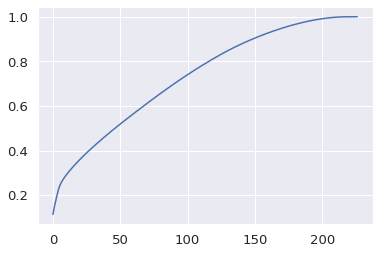

In [29]:
# Normalization and PCA 
scaler = StandardScaler()
scaled_df = cell_aggr_df.drop(columns=['geometry', 'Crime']).copy()
scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)

pca = PCA()
pca_scaled_df = pca.fit_transform(scaled_df)
np.set_printoptions(suppress=True)
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)

# Number of Features vs. Explained variance - ELBOW
plt.plot(pc_vs_variance)
# Turns out that we probably should keep most of the features

In [35]:
# Build the train-test split based on the scaled data
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size=0.33, random_state=35)

In [36]:
tuned_model = GradientBoostingRegressor(random_state=35,
                                n_estimators=155,
                                max_depth=7,
                                min_samples_split = 200,
                                min_samples_leaf  = 25,
                                max_features = 'sqrt',
                                subsample = 0.8,
                                alpha=0.8)
tuned_model.fit(X_train, y_train)

y_train_pred = tuned_model.predict(X_train)
y_test_pred = tuned_model.predict(X_test)

In [37]:
print("#########################################################")
mae = metrics.mean_absolute_error(y_train, y_train_pred)
mse = metrics.mean_squared_error(y_train, y_train_pred)
r2 = metrics.r2_score(y_train, y_train_pred)

print("The model performance for training set on Predicting Crime")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

print("#########################################################")

mae = metrics.mean_absolute_error(y_test, y_test_pred)
mse = metrics.mean_squared_error(y_test, y_test_pred)
r2 = metrics.r2_score(y_test, y_test_pred)

print("The model performance for testing set on Predicting Crime")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

#########################################################
The model performance for training set on Predicting Crime
--------------------------------------
MAE is 5.3670138758380626
MSE is 420.2037266161618
R2 score is 0.8173378134322117
#########################################################
The model performance for testing set on Predicting Crime
--------------------------------------
MAE is 6.348233112641957
MSE is 639.0421050143768
R2 score is 0.6950220375444347


In [39]:
 pd.Series(tuned_model.feature_importances_, index=scaled_df.columns).nlargest(5)
 # Liquor store making to the second most important feature

Non-Emergency Police Matter    0.102553
Liquor_License                 0.069780
Consumer Complaint             0.065288
Noise - Street/Sidewalk        0.059699
For Hire Vehicle Complaint     0.053881
dtype: float64

##### Plotting the learning curves

In [43]:
# Function to plot the learning curve of an algorithm 
#@title
def plot_learning_curve(estimator, title, X, y,
                        axes=None, ylim=None, cv=None, n_jobs=None,
                        train_sizes=np.linspace(0.1, 1.0, 5)):

    if axes is None: 
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)

    if ylim is not None: 
        axes[0].set_ylim(*ylim)

    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, 
                                                                          X, y, cv=cv, n_jobs=n_jobs, 
                                                                          train_sizes=train_sizes, return_times=True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between( train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[0].fill_between( train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[0].plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(fit_time_sorted, test_scores_mean_sorted - test_scores_std_sorted, test_scores_mean_sorted + test_scores_std_sorted, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

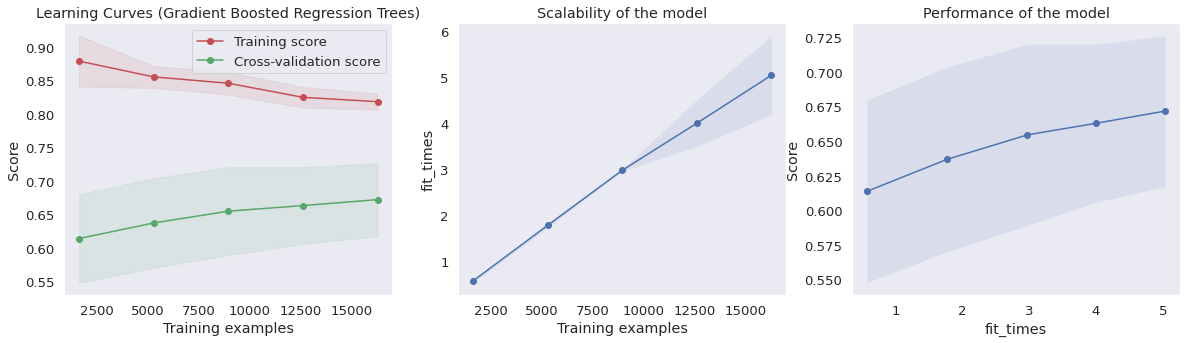

In [44]:
# Use the upadted paramters to generate the graphs 
#### RUNTIME WARNING!!! ~8min

title = "Learning Curves (Gradient Boosted Regression Trees)" 
visualization_model = GradientBoostingRegressor(random_state=35,
                                n_estimators=155,
                                max_depth=7,
                                min_samples_split = 200,
                                min_samples_leaf  = 25,
                                max_features = 'sqrt',
                                subsample = 0.8,
                                alpha=0.8)

plot_learning_curve(visualization_model, title, X_train, y_train, n_jobs=4)
plt.show()